In [1]:
import pandas as pd
import numpy as np
from catboost import Pool, CatBoostRegressor
from sklearn.model_selection import train_test_split

In [2]:
# import the police response dataset
policeResponse = pd.read_csv('policeResponses_v1.csv', low_memory = False)
policeResponse.head()

,Unnamed: 0,ADDRESS_X,LATITUDE_X,LONGITUDE_X,AGENCY,CREATE_TIME_INCIDENT,DISPOSITION_TEXT,EVENT_NUMBER,INCIDENT_TYPE_ID,INCIDENT_TYPE_DESC,...,COMMUNITY_COUNCIL_NEIGHBORHOOD,DISTRICT,ResponseTime,year,month,day,hour,minute,dayofweek,colorScale
0,3,QUEEN CITY AV / LAFEUILLE AV,39.131093,-84.588386,CPD,2019-03-25 09:47:54,NTR: NOTHING TO REPORT,CPD190325000428,HAZARD,HAZARD TO TRAFFIC/PEDESTRIAN,...,WESTWOOD,3.0,18.0,2019,Apr,25,9,49,Mon,11.0
1,8,51XX GLENCROSSING WY,39.130951,-84.617602,CPD,2019-03-25 16:10:14,301:OFFENSE REPORT,CPD190325001016,AUTOR,AUTO THEFT REPORT,...,WESTWOOD,3.0,2.0,2019,Apr,25,17,39,Mon,3.0
2,13,7XX CLIFTON COLONY DR,39.140487,-84.530967,CPD,2019-03-25 18:41:16,INV: INV,CPD190325001249,CRDAM,CRIMINAL DAMAGING,...,CLIFTON,5.0,5.0,2019,Apr,25,18,43,Mon,5.0
3,18,45XX KELLOGG AV,39.094499,-84.429425,CPD,2019-03-25 04:06:02,AST: ASSIST,CPD190325000170,FIREP-STILL,NaN,...,EAST END,2.0,4.0,2019,Apr,25,4,15,Mon,4.0
4,19,64XX CORBLY ST,39.092285,-84.379615,CPD,2019-03-25 18:00:22,NV:NO VIOLATION,CPD190325001204,FIGHT,LARGE GROUP ASSAULT,...,MOUNT WASHINGTON,2.0,4.0,2019,Apr,25,18,1,Mon,4.0


In [5]:
policeResponse.describe(include = 'all').to_csv('describe.csv')

In [6]:
policeResponse.dtypes

Unnamed: 0                          int64
ADDRESS_X                          object
LATITUDE_X                        float64
LONGITUDE_X                       float64
AGENCY                             object
CREATE_TIME_INCIDENT               object
DISPOSITION_TEXT                   object
EVENT_NUMBER                       object
INCIDENT_TYPE_ID                   object
INCIDENT_TYPE_DESC                 object
NEIGHBORHOOD                      float64
PRIORITY                          float64
PRIORITY_COLOR                     object
ARRIVAL_TIME_PRIMARY_UNIT          object
CLOSED_TIME_INCIDENT               object
DISPATCH_TIME_PRIMARY_UNIT         object
BEAT                               object
COMMUNITY_COUNCIL_NEIGHBORHOOD     object
DISTRICT                          float64
ResponseTime                      float64
year                                int64
month                              object
day                                 int64
hour                              

In [7]:
#Drop the NA Labels - will need to reexamine these in the future
policeResponse = policeResponse.dropna(subset = ['ResponseTime'])



labels = policeResponse['ResponseTime']
features = pd.DataFrame({
    'Latitude': policeResponse['LATITUDE_X'],
    'Longitude': policeResponse['LONGITUDE_X'],
    'Agency' : policeResponse['AGENCY'],
    'Priority' : policeResponse['PRIORITY'],
    'month': policeResponse['month'],
    'day': policeResponse['day'],
    'hour': policeResponse['hour'],
    'dayofweek': policeResponse['dayofweek'],
    'year': policeResponse['year'],
    'Agency': policeResponse['AGENCY'],
    'Incident Type': policeResponse['INCIDENT_TYPE_ID'],
    'Neighborhood': policeResponse['COMMUNITY_COUNCIL_NEIGHBORHOOD'],
    'Priority Color': policeResponse['PRIORITY_COLOR'],
    'Beat':policeResponse['BEAT']    
})


features.fillna('N/A', inplace = True)
features.head()



,Latitude,Longitude,Agency,Priority,month,day,hour,dayofweek,year,Incident Type,Neighborhood,Priority Color,Beat
0,39.131093,-84.588386,CPD,18,Apr,25,9,Mon,2019,HAZARD,WESTWOOD,BLUE,P331
1,39.130951,-84.617602,CPD,32,Apr,25,17,Mon,2019,AUTOR,WESTWOOD,PURPLE,P331
2,39.140487,-84.530967,CPD,26,Apr,25,18,Mon,2019,CRDAM,CLIFTON,PURPLE,P521
3,39.094499,-84.429425,CPD,5,Apr,25,4,Mon,2019,FIREP-STILL,EAST END,N/A,P241
4,39.092285,-84.379615,CPD,3,Apr,25,18,Mon,2019,FIGHT,MOUNT WASHINGTON,YELLOW,P241


In [9]:
x_train, x_test, y_train, y_test = train_test_split(features,labels, test_size = 0.25,random_state = 42)

In [10]:
train_pool = Pool(x_train, y_train, cat_features=[2,3,4,7,8,9,10,11,12])
test_pool = Pool(x_test, y_test, cat_features=[2,3,4,7,8,9,10,11,12])

In [40]:
# specify the training parameters 
RMSEmodel = CatBoostRegressor(
    random_seed = 42,
    loss_function = 'RMSE',
    od_type = 'Iter',
    task_type = 'GPU'
)

'''
'depth': 3,
 'feature_border_type': 'MinEntropy',
 'has_time': False,
 'iterations': 3,
 'l2_leaf_reg': 64,
 'learning_rate': 2.5,
 'logging_level': 'Silent',
 'loss_function': 'Logloss',
 'name': 'experiment',
 'random_seed': 1111,
 'random_strength': 1
'''

"\n'depth': 3,\n 'feature_border_type': 'MinEntropy',\n 'has_time': False,\n 'iterations': 3,\n 'l2_leaf_reg': 64,\n 'learning_rate': 2.5,\n 'logging_level': 'Silent',\n 'loss_function': 'Logloss',\n 'name': 'experiment',\n 'random_seed': 1111,\n 'random_strength': 1\n"

In [41]:
#train_pool.get_features()

In [42]:
import time

startTime = time.time()
#train the model
RMSEmodel.fit(train_pool)

print("Total Training Time: %.2f minutes" % ((time.time() - startTime)/60))


0:	learn: 17.4779039	total: 88.6ms	remaining: 1m 28s
1:	learn: 17.3026699	total: 173ms	remaining: 1m 26s
2:	learn: 17.1366339	total: 232ms	remaining: 1m 17s
3:	learn: 16.9777080	total: 314ms	remaining: 1m 18s
4:	learn: 16.8261949	total: 385ms	remaining: 1m 16s
5:	learn: 16.6829433	total: 435ms	remaining: 1m 11s
6:	learn: 16.5477017	total: 507ms	remaining: 1m 11s
7:	learn: 16.4171731	total: 579ms	remaining: 1m 11s
8:	learn: 16.2945387	total: 647ms	remaining: 1m 11s
9:	learn: 16.1784431	total: 727ms	remaining: 1m 11s
10:	learn: 16.0686790	total: 795ms	remaining: 1m 11s
11:	learn: 15.9636876	total: 883ms	remaining: 1m 12s
12:	learn: 15.8636630	total: 949ms	remaining: 1m 12s
13:	learn: 15.7689347	total: 1.02s	remaining: 1m 12s
14:	learn: 15.6796888	total: 1.1s	remaining: 1m 12s
15:	learn: 15.5943329	total: 1.17s	remaining: 1m 11s
16:	learn: 15.5138263	total: 1.24s	remaining: 1m 11s
17:	learn: 15.4373471	total: 1.3s	remaining: 1m 10s
18:	learn: 15.3645845	total: 1.38s	remaining: 1m 11s
19:	

158:	learn: 14.0632064	total: 11.7s	remaining: 1m 1s
159:	learn: 14.0630537	total: 11.7s	remaining: 1m 1s
160:	learn: 14.0629036	total: 11.8s	remaining: 1m 1s
161:	learn: 14.0627176	total: 11.9s	remaining: 1m 1s
162:	learn: 14.0624842	total: 12s	remaining: 1m 1s
163:	learn: 14.0623215	total: 12.1s	remaining: 1m 1s
164:	learn: 14.0621007	total: 12.1s	remaining: 1m 1s
165:	learn: 14.0616492	total: 12.2s	remaining: 1m 1s
166:	learn: 14.0608196	total: 12.2s	remaining: 1m 1s
167:	learn: 14.0605681	total: 12.3s	remaining: 1m
168:	learn: 14.0603827	total: 12.4s	remaining: 1m
169:	learn: 14.0601419	total: 12.4s	remaining: 1m
170:	learn: 14.0600045	total: 12.5s	remaining: 1m
171:	learn: 14.0598231	total: 12.6s	remaining: 1m
172:	learn: 14.0596477	total: 12.7s	remaining: 1m
173:	learn: 14.0594022	total: 12.7s	remaining: 1m
174:	learn: 14.0590927	total: 12.8s	remaining: 1m
175:	learn: 14.0589833	total: 12.8s	remaining: 1m
176:	learn: 14.0586952	total: 12.9s	remaining: 1m
177:	learn: 14.0583870	to

317:	learn: 14.0315494	total: 22.4s	remaining: 48s
318:	learn: 14.0314324	total: 22.4s	remaining: 47.9s
319:	learn: 14.0303296	total: 22.5s	remaining: 47.8s
320:	learn: 14.0302808	total: 22.5s	remaining: 47.7s
321:	learn: 14.0302554	total: 22.6s	remaining: 47.6s
322:	learn: 14.0301846	total: 22.7s	remaining: 47.6s
323:	learn: 14.0301030	total: 22.8s	remaining: 47.5s
324:	learn: 14.0300362	total: 22.8s	remaining: 47.4s
325:	learn: 14.0298664	total: 22.9s	remaining: 47.3s
326:	learn: 14.0296739	total: 22.9s	remaining: 47.2s
327:	learn: 14.0296565	total: 23s	remaining: 47.1s
328:	learn: 14.0295362	total: 23.1s	remaining: 47.1s
329:	learn: 14.0295329	total: 23.1s	remaining: 47s
330:	learn: 14.0294326	total: 23.2s	remaining: 46.9s
331:	learn: 14.0293584	total: 23.3s	remaining: 46.8s
332:	learn: 14.0291231	total: 23.4s	remaining: 46.8s
333:	learn: 14.0280622	total: 23.4s	remaining: 46.7s
334:	learn: 14.0279138	total: 23.5s	remaining: 46.7s
335:	learn: 14.0277667	total: 23.6s	remaining: 46.7s

473:	learn: 14.0111756	total: 32.9s	remaining: 36.5s
474:	learn: 14.0109701	total: 33s	remaining: 36.5s
475:	learn: 14.0107640	total: 33.1s	remaining: 36.4s
476:	learn: 14.0105605	total: 33.2s	remaining: 36.4s
477:	learn: 14.0103972	total: 33.2s	remaining: 36.3s
478:	learn: 14.0103269	total: 33.3s	remaining: 36.2s
479:	learn: 14.0100090	total: 33.4s	remaining: 36.1s
480:	learn: 14.0094875	total: 33.4s	remaining: 36.1s
481:	learn: 14.0093744	total: 33.5s	remaining: 36s
482:	learn: 14.0093329	total: 33.6s	remaining: 35.9s
483:	learn: 14.0092813	total: 33.6s	remaining: 35.8s
484:	learn: 14.0091046	total: 33.7s	remaining: 35.8s
485:	learn: 14.0088743	total: 33.8s	remaining: 35.7s
486:	learn: 14.0088000	total: 33.8s	remaining: 35.6s
487:	learn: 14.0087337	total: 33.9s	remaining: 35.5s
488:	learn: 14.0086394	total: 33.9s	remaining: 35.5s
489:	learn: 14.0085316	total: 34s	remaining: 35.4s
490:	learn: 14.0085001	total: 34.1s	remaining: 35.3s
491:	learn: 14.0084298	total: 34.1s	remaining: 35.3s

630:	learn: 13.9939791	total: 43.7s	remaining: 25.6s
631:	learn: 13.9938692	total: 43.8s	remaining: 25.5s
632:	learn: 13.9938123	total: 43.9s	remaining: 25.4s
633:	learn: 13.9937057	total: 43.9s	remaining: 25.4s
634:	learn: 13.9936555	total: 44s	remaining: 25.3s
635:	learn: 13.9935616	total: 44.1s	remaining: 25.2s
636:	learn: 13.9935429	total: 44.1s	remaining: 25.2s
637:	learn: 13.9934685	total: 44.2s	remaining: 25.1s
638:	learn: 13.9934256	total: 44.3s	remaining: 25s
639:	learn: 13.9933485	total: 44.4s	remaining: 25s
640:	learn: 13.9932721	total: 44.4s	remaining: 24.9s
641:	learn: 13.9932138	total: 44.5s	remaining: 24.8s
642:	learn: 13.9928941	total: 44.6s	remaining: 24.8s
643:	learn: 13.9924706	total: 44.6s	remaining: 24.7s
644:	learn: 13.9924096	total: 44.7s	remaining: 24.6s
645:	learn: 13.9923164	total: 44.8s	remaining: 24.5s
646:	learn: 13.9922648	total: 44.9s	remaining: 24.5s
647:	learn: 13.9922192	total: 44.9s	remaining: 24.4s
648:	learn: 13.9921455	total: 45s	remaining: 24.3s
6

788:	learn: 13.9795779	total: 54.5s	remaining: 14.6s
789:	learn: 13.9795437	total: 54.6s	remaining: 14.5s
790:	learn: 13.9794639	total: 54.7s	remaining: 14.4s
791:	learn: 13.9794471	total: 54.7s	remaining: 14.4s
792:	learn: 13.9794216	total: 54.8s	remaining: 14.3s
793:	learn: 13.9793988	total: 54.9s	remaining: 14.2s
794:	learn: 13.9793404	total: 54.9s	remaining: 14.2s
795:	learn: 13.9792988	total: 55s	remaining: 14.1s
796:	learn: 13.9792411	total: 55.1s	remaining: 14s
797:	learn: 13.9792190	total: 55.1s	remaining: 14s
798:	learn: 13.9791600	total: 55.2s	remaining: 13.9s
799:	learn: 13.9791224	total: 55.3s	remaining: 13.8s
800:	learn: 13.9790936	total: 55.3s	remaining: 13.8s
801:	learn: 13.9789238	total: 55.4s	remaining: 13.7s
802:	learn: 13.9788554	total: 55.5s	remaining: 13.6s
803:	learn: 13.9787568	total: 55.5s	remaining: 13.5s
804:	learn: 13.9787085	total: 55.6s	remaining: 13.5s
805:	learn: 13.9785012	total: 55.7s	remaining: 13.4s
806:	learn: 13.9784079	total: 55.7s	remaining: 13.3s

946:	learn: 13.9666149	total: 1m 5s	remaining: 3.66s
947:	learn: 13.9665880	total: 1m 5s	remaining: 3.6s
948:	learn: 13.9665713	total: 1m 5s	remaining: 3.52s
949:	learn: 13.9664618	total: 1m 5s	remaining: 3.46s
950:	learn: 13.9664444	total: 1m 5s	remaining: 3.39s
951:	learn: 13.9663752	total: 1m 5s	remaining: 3.32s
952:	learn: 13.9663127	total: 1m 5s	remaining: 3.25s
953:	learn: 13.9661939	total: 1m 5s	remaining: 3.18s
954:	learn: 13.9654163	total: 1m 6s	remaining: 3.11s
955:	learn: 13.9653586	total: 1m 6s	remaining: 3.04s
956:	learn: 13.9653371	total: 1m 6s	remaining: 2.97s
957:	learn: 13.9652686	total: 1m 6s	remaining: 2.9s
958:	learn: 13.9652014	total: 1m 6s	remaining: 2.83s
959:	learn: 13.9649993	total: 1m 6s	remaining: 2.76s
960:	learn: 13.9649013	total: 1m 6s	remaining: 2.69s
961:	learn: 13.9648784	total: 1m 6s	remaining: 2.63s
962:	learn: 13.9647562	total: 1m 6s	remaining: 2.56s
963:	learn: 13.9647280	total: 1m 6s	remaining: 2.49s
964:	learn: 13.9647005	total: 1m 6s	remaining: 2

In [43]:
print(pd.DataFrame(RMSEmodel.eval_metrics(train_pool, metrics = ['RMSE','MAE'])))

          RMSE       MAE
0    17.476479  9.667270
1    17.301144  9.378484
2    17.134537  9.102471
3    16.973976  8.839648
4    16.821726  8.596244
5    16.679857  8.373772
6    16.542860  8.163294
7    16.411097  7.968173
8    16.289202  7.789455
9    16.172245  7.622459
10   16.061669  7.467831
11   15.957181  7.326063
12   15.857124  7.196779
13   15.761277  7.079550
14   15.671784  6.971611
15   15.585856  6.872513
16   15.503919  6.781312
17   15.427408  6.700796
18   15.352722  6.625430
19   15.284264  6.558365
20   15.219587  6.498166
21   15.156535  6.444036
22   15.098917  6.397503
23   15.044319  6.356514
24   14.992067  6.319403
25   14.943101  6.286074
26   14.895508  6.256384
27   14.850600  6.230800
28   14.808518  6.208000
29   14.769479  6.189200
..         ...       ...
970  13.957866  6.636843
971  13.957674  6.636668
972  13.957647  6.636687
973  13.957645  6.636702
974  13.957627  6.636710
975  13.957620  6.636686
976  13.957545  6.636680
977  13.957506  6.636657


In [44]:
RMSEmodel.get_feature_importance(train_pool, fstr_type = 'FeatureImportance', prettified = True)

[('Incident Type', 32.3682158444107),
 ('hour', 20.613703819818348),
 ('Neighborhood', 7.104573448210397),
 ('Beat', 6.753444064883151),
 ('Priority', 6.270647782673495),
 ('Longitude', 5.663698609798379),
 ('year', 4.306825118166485),
 ('Latitude', 3.896709834654345),
 ('Priority Color', 3.350894928840135),
 ('Agency', 2.9130456310842914),
 ('month', 2.605254890186674),
 ('dayofweek', 2.404061439142735),
 ('day', 1.7489245881308582)]

In [45]:
# make the prediction using the resulting model
RMSEpreds = RMSEmodel.predict(test_pool)
print(preds)

[4.14484414 3.70285241 4.19594237 ... 5.50724448 5.12095806 7.51968212]


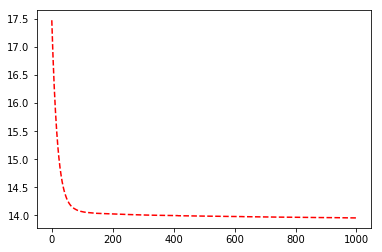

In [46]:
import matplotlib.pyplot as plt


trainSet =  RMSEmodel.eval_metrics(train_pool, metrics = ['RMSE'])
#print(trainSet['RMSE'])
t = np.arange(0., 1000, 1)


# red dashes, blue squares and green triangles
plt.plot(t, trainSet['RMSE'], 'r--')#, t, preds, 'bs')


(-1, 100)

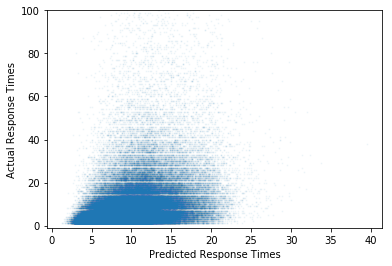

In [61]:
plt.scatter(RMSEpreds, y_test, s = 0.7, alpha = 0.05)
plt.xlabel('Predicted Response Times')
plt.ylabel('Actual Response Times')
plt.ylim(-1,100)

In [48]:
score = RMSEmodel.score(x_test,y_test)
print(score)

14.505393674332733


In [62]:
import scipy.stats as stats

slope, intercept, r_value, p_value, std_err = stats.linregress(RMSEpreds, y_test)
print(r_value**2)

0.07203667437089345


In [49]:
RMSEmodel.save_model('RMSEcatBoostV1.cbm', 
           format="cbm", 
           export_parameters=None,
           pool=None)

# Try the model again, but using mean absolute error instead of mean squared error as the loss function

In [50]:
# specify the training parameters 
modelMAE = CatBoostRegressor(
    random_seed = 42,
    loss_function = 'MAE',
    od_type = 'Iter',
    task_type = 'GPU'
)


In [52]:
import time

startTime = time.time()
#train the model
modelMAE.fit(train_pool)

print("Total Training Time: %.2f minutes" % ((time.time() - startTime)/60))


0:	learn: 9.9514016	total: 68.1ms	remaining: 1m 7s
1:	learn: 9.9363396	total: 140ms	remaining: 1m 9s
2:	learn: 9.9213867	total: 197ms	remaining: 1m 5s
3:	learn: 9.9063446	total: 265ms	remaining: 1m 6s
4:	learn: 9.8913928	total: 342ms	remaining: 1m 7s
5:	learn: 9.8763273	total: 360ms	remaining: 59.7s
6:	learn: 9.8613754	total: 422ms	remaining: 59.8s
7:	learn: 9.8464119	total: 478ms	remaining: 59.2s
8:	learn: 9.8313528	total: 529ms	remaining: 58.2s
9:	learn: 9.8164081	total: 590ms	remaining: 58.4s
10:	learn: 9.8013349	total: 651ms	remaining: 58.5s
11:	learn: 9.7864136	total: 703ms	remaining: 57.9s
12:	learn: 9.7713422	total: 760ms	remaining: 57.7s
13:	learn: 9.7563969	total: 823ms	remaining: 57.9s
14:	learn: 9.7413272	total: 899ms	remaining: 59s
15:	learn: 9.7263743	total: 959ms	remaining: 59s
16:	learn: 9.7114260	total: 1.03s	remaining: 59.5s
17:	learn: 9.6963569	total: 1.1s	remaining: 1m
18:	learn: 9.6814081	total: 1.18s	remaining: 1m
19:	learn: 9.6663660	total: 1.26s	remaining: 1m 1s


166:	learn: 7.9234521	total: 11.2s	remaining: 55.9s
167:	learn: 7.9160237	total: 11.3s	remaining: 55.8s
168:	learn: 7.9086222	total: 11.3s	remaining: 55.7s
169:	learn: 7.9012395	total: 11.4s	remaining: 55.7s
170:	learn: 7.8938750	total: 11.5s	remaining: 55.6s
171:	learn: 7.8865298	total: 11.5s	remaining: 55.4s
172:	learn: 7.8791828	total: 11.6s	remaining: 55.4s
173:	learn: 7.8718476	total: 11.6s	remaining: 55.3s
174:	learn: 7.8645041	total: 11.7s	remaining: 55.2s
175:	learn: 7.8571830	total: 11.8s	remaining: 55.2s
176:	learn: 7.8498325	total: 11.8s	remaining: 55.1s
177:	learn: 7.8424826	total: 11.9s	remaining: 55s
178:	learn: 7.8351632	total: 12s	remaining: 54.9s
179:	learn: 7.8278332	total: 12s	remaining: 54.8s
180:	learn: 7.8204921	total: 12.1s	remaining: 54.8s
181:	learn: 7.8131756	total: 12.2s	remaining: 54.7s
182:	learn: 7.8058381	total: 12.2s	remaining: 54.6s
183:	learn: 7.7985058	total: 12.3s	remaining: 54.5s
184:	learn: 7.7912080	total: 12.3s	remaining: 54.4s
185:	learn: 7.7838

326:	learn: 7.0006775	total: 21.5s	remaining: 44.3s
327:	learn: 6.9968830	total: 21.6s	remaining: 44.3s
328:	learn: 6.9931641	total: 21.7s	remaining: 44.2s
329:	learn: 6.9894335	total: 21.7s	remaining: 44.1s
330:	learn: 6.9857146	total: 21.8s	remaining: 44s
331:	learn: 6.9820391	total: 21.8s	remaining: 44s
332:	learn: 6.9783905	total: 21.9s	remaining: 43.9s
333:	learn: 6.9747724	total: 22s	remaining: 43.8s
334:	learn: 6.9711819	total: 22s	remaining: 43.8s
335:	learn: 6.9675902	total: 22.1s	remaining: 43.7s
336:	learn: 6.9640143	total: 22.2s	remaining: 43.6s
337:	learn: 6.9604771	total: 22.2s	remaining: 43.5s
338:	learn: 6.9569785	total: 22.3s	remaining: 43.5s
339:	learn: 6.9534648	total: 22.4s	remaining: 43.4s
340:	learn: 6.9499815	total: 22.4s	remaining: 43.3s
341:	learn: 6.9465398	total: 22.5s	remaining: 43.3s
342:	learn: 6.9431239	total: 22.6s	remaining: 43.2s
343:	learn: 6.9396987	total: 22.6s	remaining: 43.2s
344:	learn: 6.9363045	total: 22.7s	remaining: 43.1s
345:	learn: 6.932939

488:	learn: 6.5750685	total: 32s	remaining: 33.5s
489:	learn: 6.5733078	total: 32.1s	remaining: 33.4s
490:	learn: 6.5715424	total: 32.1s	remaining: 33.3s
491:	learn: 6.5697870	total: 32.2s	remaining: 33.2s
492:	learn: 6.5680463	total: 32.3s	remaining: 33.2s
493:	learn: 6.5663073	total: 32.3s	remaining: 33.1s
494:	learn: 6.5645741	total: 32.4s	remaining: 33s
495:	learn: 6.5628545	total: 32.4s	remaining: 33s
496:	learn: 6.5611494	total: 32.5s	remaining: 32.9s
497:	learn: 6.5594327	total: 32.6s	remaining: 32.8s
498:	learn: 6.5577148	total: 32.6s	remaining: 32.8s
499:	learn: 6.5560092	total: 32.7s	remaining: 32.7s
500:	learn: 6.5542960	total: 32.7s	remaining: 32.6s
501:	learn: 6.5525963	total: 32.8s	remaining: 32.5s
502:	learn: 6.5509065	total: 32.8s	remaining: 32.4s
503:	learn: 6.5492085	total: 32.9s	remaining: 32.4s
504:	learn: 6.5475269	total: 32.9s	remaining: 32.3s
505:	learn: 6.5458331	total: 33s	remaining: 32.2s
506:	learn: 6.5441468	total: 33s	remaining: 32.1s
507:	learn: 6.5424699	

649:	learn: 6.3662086	total: 41.9s	remaining: 22.6s
650:	learn: 6.3652989	total: 42s	remaining: 22.5s
651:	learn: 6.3643928	total: 42s	remaining: 22.4s
652:	learn: 6.3634931	total: 42.1s	remaining: 22.3s
653:	learn: 6.3626051	total: 42.1s	remaining: 22.3s
654:	learn: 6.3617031	total: 42.2s	remaining: 22.2s
655:	learn: 6.3608122	total: 42.2s	remaining: 22.2s
656:	learn: 6.3599342	total: 42.3s	remaining: 22.1s
657:	learn: 6.3590544	total: 42.3s	remaining: 22s
658:	learn: 6.3581729	total: 42.4s	remaining: 21.9s
659:	learn: 6.3573066	total: 42.5s	remaining: 21.9s
660:	learn: 6.3564398	total: 42.5s	remaining: 21.8s
661:	learn: 6.3555835	total: 42.6s	remaining: 21.7s
662:	learn: 6.3547359	total: 42.7s	remaining: 21.7s
663:	learn: 6.3538890	total: 42.7s	remaining: 21.6s
664:	learn: 6.3530456	total: 42.8s	remaining: 21.5s
665:	learn: 6.3522115	total: 42.8s	remaining: 21.5s
666:	learn: 6.3513740	total: 42.9s	remaining: 21.4s
667:	learn: 6.3505311	total: 43s	remaining: 21.3s
668:	learn: 6.349698

811:	learn: 6.2573909	total: 52.2s	remaining: 12.1s
812:	learn: 6.2568939	total: 52.3s	remaining: 12s
813:	learn: 6.2564074	total: 52.4s	remaining: 12s
814:	learn: 6.2559309	total: 52.4s	remaining: 11.9s
815:	learn: 6.2554491	total: 52.5s	remaining: 11.8s
816:	learn: 6.2549761	total: 52.6s	remaining: 11.8s
817:	learn: 6.2545102	total: 52.6s	remaining: 11.7s
818:	learn: 6.2540284	total: 52.7s	remaining: 11.6s
819:	learn: 6.2535513	total: 52.8s	remaining: 11.6s
820:	learn: 6.2530736	total: 52.8s	remaining: 11.5s
821:	learn: 6.2526176	total: 52.9s	remaining: 11.5s
822:	learn: 6.2521710	total: 53s	remaining: 11.4s
823:	learn: 6.2517132	total: 53s	remaining: 11.3s
824:	learn: 6.2512584	total: 53.1s	remaining: 11.3s
825:	learn: 6.2507854	total: 53.2s	remaining: 11.2s
826:	learn: 6.2503358	total: 53.2s	remaining: 11.1s
827:	learn: 6.2498927	total: 53.3s	remaining: 11.1s
828:	learn: 6.2494491	total: 53.3s	remaining: 11s
829:	learn: 6.2490048	total: 53.4s	remaining: 10.9s
830:	learn: 6.2485476	

973:	learn: 6.1972519	total: 1m 2s	remaining: 1.66s
974:	learn: 6.1969794	total: 1m 2s	remaining: 1.59s
975:	learn: 6.1967039	total: 1m 2s	remaining: 1.53s
976:	learn: 6.1964361	total: 1m 2s	remaining: 1.46s
977:	learn: 6.1961618	total: 1m 2s	remaining: 1.4s
978:	learn: 6.1958875	total: 1m 2s	remaining: 1.34s
979:	learn: 6.1955979	total: 1m 2s	remaining: 1.27s
980:	learn: 6.1953312	total: 1m 2s	remaining: 1.21s
981:	learn: 6.1950435	total: 1m 2s	remaining: 1.15s
982:	learn: 6.1947768	total: 1m 2s	remaining: 1.08s
983:	learn: 6.1945060	total: 1m 2s	remaining: 1.02s
984:	learn: 6.1942393	total: 1m 2s	remaining: 954ms
985:	learn: 6.1939761	total: 1m 2s	remaining: 891ms
986:	learn: 6.1937106	total: 1m 2s	remaining: 827ms
987:	learn: 6.1934480	total: 1m 2s	remaining: 763ms
988:	learn: 6.1931907	total: 1m 2s	remaining: 700ms
989:	learn: 6.1929123	total: 1m 2s	remaining: 636ms
990:	learn: 6.1926509	total: 1m 3s	remaining: 572ms
991:	learn: 6.1923954	total: 1m 3s	remaining: 509ms
992:	learn: 6

In [53]:
print(pd.DataFrame(modelMAE.eval_metrics(train_pool, metrics = ['RMSE','MAE'])))

          RMSE       MAE
0    17.654718  9.951356
1    17.646269  9.936357
2    17.637828  9.921358
3    17.629395  9.906360
4    17.620970  9.891360
5    17.612555  9.876360
6    17.604148  9.861360
7    17.595750  9.846361
8    17.587361  9.831362
9    17.578981  9.816363
10   17.570610  9.801365
11   17.562247  9.786366
12   17.553894  9.771368
13   17.545550  9.756370
14   17.537214  9.741372
15   17.528887  9.726373
16   17.520569  9.711375
17   17.512260  9.696375
18   17.503959  9.681376
19   17.495668  9.666377
20   17.487386  9.651380
21   17.479112  9.636380
22   17.470848  9.621382
23   17.462593  9.606385
24   17.454346  9.591385
25   17.446108  9.576386
26   17.437879  9.561387
27   17.429661  9.546390
28   17.421450  9.531392
29   17.413249  9.516393
..         ...       ...
970  14.848146  6.172999
971  14.847548  6.172696
972  14.846961  6.172399
973  14.846360  6.172080
974  14.845765  6.171789
975  14.845183  6.171484
976  14.844604  6.171180
977  14.844017  6.170878


In [54]:
modelMAE.get_feature_importance(train_pool, fstr_type = 'FeatureImportance', prettified = True)

[('Incident Type', 37.75936201064316),
 ('hour', 23.44599855125261),
 ('Neighborhood', 19.16493774201181),
 ('Beat', 14.965245349470187),
 ('year', 0.966614707487923),
 ('Priority', 0.9390745198164695),
 ('Latitude', 0.9299303237745261),
 ('Priority Color', 0.8492765768251177),
 ('Longitude', 0.48625752700517516),
 ('Agency', 0.16900539643368517),
 ('dayofweek', 0.15268988730031313),
 ('month', 0.13511318306313164),
 ('day', 0.0364942249158909)]

In [55]:
# make the prediction using the resulting model
MAEpreds = modelMAE.predict(test_pool)
print(MAEpreds)

[4.14484414 3.70285241 4.19594237 ... 5.50724448 5.12095806 7.51968212]


(-1, 100)

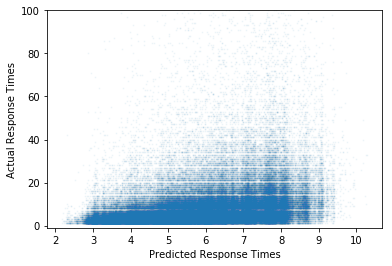

In [59]:
plt.scatter(MAEpreds, y_test, s = 0.7, alpha = 0.05)
plt.xlabel('Predicted Response Times')
plt.ylabel('Actual Response Times')
plt.ylim(-1,100)

In [63]:
slope, intercept, r_value, p_value, std_err = stats.linregress(MAEpreds, y_test)
print(r_value**2)

0.05331785698736652


In [64]:
score = modelMAE.score(x_test,y_test)
print(score)

15.308468035247778


In [65]:
np.absolute(y_test - MAEpreds).describe()

count    142180.000000
mean          6.195050
std          13.998997
min           0.000030
25%           1.342811
50%           2.899961
75%           5.661291
max        1629.382680
Name: ResponseTime, dtype: float64

In [66]:
np.absolute(y_test - RMSEpreds).describe()

count    142180.000000
mean          6.702225
std          12.864206
min           0.000003
25%           2.123257
50%           4.348066
75%           7.549579
max        1628.518910
Name: ResponseTime, dtype: float64

In [67]:
import csv
from hyperopt import STATUS_OK
from catboost import cv


#Create an objective function to minimize
def objective(params_space):
    
    global ITERATION
    global CV_SCORES
    
    ITERATION += 1
    
    #model = CatBoostRegressor(iterations = params_space['iterations'], 
    #                          learning_rate = params_space['learning_rate'], 
    #                          loss_function = params_space['loss_function'], 
    #                          max_depth = params_space['max_depth'],
    #                         )
        # Make sure parameters that need to be integers are integers
    #for parameter_name in [params_space['max_depth']]:
    #    params[parameter_name] = int(params[parameter_name])
    
    startTime = time.time()
       
    #train the model
    #model.fit(train_pool)
    #best_score = model.score(test_pool)

    scores = cv(train_pool, params_space, partition_random_seed = 42, fold_count = 9, logging_level = 'Silent',
               early_stopping_rounds = 20)
    best_score = scores['test-MAE-mean'].min()  #scores.iat[-1,0] #tail(n = 1)['test-RMSE-mean']
    scores['iteration'] = ITERATION
    CV_SCORES = CV_SCORES.append(scores, ignore_index = True)
    #print(scores)
    #best_score = np.min(model.eval_metrics(train_pool, metrics = ['RMSE'])['RMSE'])

    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([best_score, params_space, ITERATION, (time.time() - startTime)/60])

    #print(pd.DataFrame(model.eval_metrics(train_pool, metrics = ['RMSE','MAE'])))
    print('Achieved MAE of ' + str(best_score) + ' with parameters: ' + str(params_space))
    print("Total Training Time: %.2f minutes" % ((time.time() - startTime)/60))
    return {'loss': best_score,
            'status': STATUS_OK}
    
    


In [68]:
from hyperopt import hp

params_space = {'iterations': 1000,
                'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
                'loss_function': 'MAE',
                'max_depth': hp.quniform('max_depth', 2, 10, 1),
                'random_seed': 42,
                'bootstrap_type': 'Bayesian',
                #'rsm': hp.uniform('reg_alpha', 0.5, 1.0), #Cant use this with GPU - use if training on CPU
                'bagging_temperature': hp.uniform('bagging_temperature', 0.0, 100),
                'random_strength': hp.uniform('random_strength', 0.0, 100),
                #'thread_count': 2, #Don't use with GPU.  Had it for CPU to keep PC temp under control, although training is longer
                'task_type': 'GPU'
                
               }

In [69]:
from hyperopt import Trials

# Keep track of results
bayes_trials = Trials()

In [71]:
# File to save first results
out_file = 'results/gbm_trials.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'train_time'])
of_connection.close()

In [72]:
from hyperopt import tpe

# optimization algorithm
tpe_algorithm = tpe.suggest

In [73]:
from hyperopt import fmin

In [74]:

MAX_EVALS = 100


# Global variable
global  ITERATION
global CV_SCORES

CV_SCORES = pd.DataFrame()

ITERATION = 0

# Run optimization
best = fmin(fn = objective, space = params_space, algo = tpe.suggest, 
            max_evals = MAX_EVALS, trials = bayes_trials, rstate = np.random.RandomState(42))

CV_SCORES.to_csv('results/cv_scores.csv')
#print(CV_SCORES)


Achieved MAE of 7.594821932212211 with parameters: {'bagging_temperature': 31.944725103976733, 'bootstrap_type': 'Bayesian', 'iterations': 1000, 'learning_rate': 0.006450515080504199, 'loss_function': 'MAE', 'max_depth': 9.0, 'random_seed': 42, 'random_strength': 45.470105222137214, 'task_type': 'GPU'}
Total Training Time: 12.99 minutes
Achieved MAE of 6.10665905009413 with parameters: {'bagging_temperature': 31.579959348704868, 'bootstrap_type': 'Bayesian', 'iterations': 1000, 'learning_rate': 0.1561278943249286, 'loss_function': 'MAE', 'max_depth': 8.0, 'random_seed': 42, 'random_strength': 41.01039588533138, 'task_type': 'GPU'}
Total Training Time: 15.85 minutes
Achieved MAE of 6.763570554840495 with parameters: {'bagging_temperature': 95.12239065933292, 'bootstrap_type': 'Bayesian', 'iterations': 1000, 'learning_rate': 0.015312679841029722, 'loss_function': 'MAE', 'max_depth': 9.0, 'random_seed': 42, 'random_strength': 83.73883555532842, 'task_type': 'GPU'}
Total Training Time: 2.6

Achieved MAE of 6.10879895823809 with parameters: {'bagging_temperature': 16.610204131736275, 'bootstrap_type': 'Bayesian', 'iterations': 1000, 'learning_rate': 0.18503022705500094, 'loss_function': 'MAE', 'max_depth': 7.0, 'random_seed': 42, 'random_strength': 25.42582218431162, 'task_type': 'GPU'}
Total Training Time: 15.00 minutes
Achieved MAE of 6.066083657455273 with parameters: {'bagging_temperature': 0.24876594055634937, 'bootstrap_type': 'Bayesian', 'iterations': 1000, 'learning_rate': 0.13171835223249723, 'loss_function': 'MAE', 'max_depth': 5.0, 'random_seed': 42, 'random_strength': 34.65584060410642, 'task_type': 'GPU'}
Total Training Time: 12.40 minutes
Achieved MAE of 6.515861900608857 with parameters: {'bagging_temperature': 59.64754646219706, 'bootstrap_type': 'Bayesian', 'iterations': 1000, 'learning_rate': 0.14208695996220946, 'loss_function': 'MAE', 'max_depth': 5.0, 'random_seed': 42, 'random_strength': 17.17340970677606, 'task_type': 'GPU'}
Total Training Time: 2.56

Achieved MAE of 6.3104643471726956 with parameters: {'bagging_temperature': 15.825099563770372, 'bootstrap_type': 'Bayesian', 'iterations': 1000, 'learning_rate': 0.025507912100712342, 'loss_function': 'MAE', 'max_depth': 7.0, 'random_seed': 42, 'random_strength': 57.19212342366684, 'task_type': 'GPU'}
Total Training Time: 14.93 minutes
Achieved MAE of 6.515850764411997 with parameters: {'bagging_temperature': 37.503858228648426, 'bootstrap_type': 'Bayesian', 'iterations': 1000, 'learning_rate': 0.11427043430348763, 'loss_function': 'MAE', 'max_depth': 6.0, 'random_seed': 42, 'random_strength': 40.55158315416355, 'task_type': 'GPU'}
Total Training Time: 2.56 minutes
Achieved MAE of 6.645865203370399 with parameters: {'bagging_temperature': 93.08714141463138, 'bootstrap_type': 'Bayesian', 'iterations': 1000, 'learning_rate': 0.01796001765083996, 'loss_function': 'MAE', 'max_depth': 9.0, 'random_seed': 42, 'random_strength': 67.35412919692816, 'task_type': 'GPU'}
Total Training Time: 2.5

Achieved MAE of 6.189649432522852 with parameters: {'bagging_temperature': 22.826998027080887, 'bootstrap_type': 'Bayesian', 'iterations': 1000, 'learning_rate': 0.1224395174682441, 'loss_function': 'MAE', 'max_depth': 2.0, 'random_seed': 42, 'random_strength': 16.719471525989068, 'task_type': 'GPU'}
Total Training Time: 2.78 minutes
Achieved MAE of 6.13614835875903 with parameters: {'bagging_temperature': 12.41863998889087, 'bootstrap_type': 'Bayesian', 'iterations': 1000, 'learning_rate': 0.1410934404842819, 'loss_function': 'MAE', 'max_depth': 4.0, 'random_seed': 42, 'random_strength': 24.92310641218312, 'task_type': 'GPU'}
Total Training Time: 11.19 minutes
Achieved MAE of 6.074826817485938 with parameters: {'bagging_temperature': 0.44511006617800786, 'bootstrap_type': 'Bayesian', 'iterations': 1000, 'learning_rate': 0.19985340259223094, 'loss_function': 'MAE', 'max_depth': 3.0, 'random_seed': 42, 'random_strength': 71.4948817404542, 'task_type': 'GPU'}
Total Training Time: 9.24 mi

In [75]:
CV_SCORES.to_csv('results/cv_scores.csv')


In [76]:
evaluation = pd.read_csv(out_file)

In [77]:
evaluation.head()

,loss,params,iteration,train_time
0,7.594822,"{'bagging_temperature': 31.944725103976733, 'b...",1,12.988190
1,6.106659,"{'bagging_temperature': 31.579959348704868, 'b...",2,15.854232
2,6.763571,"{'bagging_temperature': 95.12239065933292, 'bo...",3,2.603682
3,7.415420,"{'bagging_temperature': 43.3332801870225, 'boo...",4,2.623279
4,6.515809,"{'bagging_temperature': 80.27647811563104, 'bo...",5,2.638401


In [78]:
evaluation.describe()

,loss,iteration,train_time
count,100.000000,100.000000,100.000000
mean,6.392668,50.500000,9.812887
std,0.369905,29.011492,6.473776
min,6.026423,1.000000,2.558414
25%,6.117721,25.750000,2.597805
50%,6.207876,50.500000,11.191875
75%,6.515864,75.250000,15.248086
max,7.833384,100.000000,20.968797


In [79]:
CV_SCORES.describe(include = 'all')

,test-MAE-mean,test-MAE-std,train-MAE-mean,train-MAE-std,iteration
count,88765.000000,88765.000000,88765.000000,88765.000000,88765.000000
mean,6.883451,0.067421,6.883803,0.008092,50.406771
std,0.981704,0.005239,0.981926,0.000876,28.898108
min,6.026423,0.060234,5.955976,0.005367,1.000000
25%,6.152695,0.063270,6.157073,0.007483,25.000000
50%,6.515902,0.065399,6.515932,0.007923,51.000000
75%,7.269123,0.071229,7.269475,0.008673,76.000000
max,9.963606,0.077833,9.963618,0.012020,100.000000


In [80]:
#Find the best score iteration
bestOverallScore = CV_SCORES.loc[CV_SCORES['test-MAE-mean'] == CV_SCORES['test-MAE-mean'].min()]
bestOverallScore.head()

,test-MAE-mean,test-MAE-std,train-MAE-mean,train-MAE-std,iteration
31327,6.026423,0.06136,5.955976,0.006152,35


In [81]:
bestCV = CV_SCORES.loc[CV_SCORES['iteration'] == np.mean(bestOverallScore['iteration'])]
bestCV.tail()

,test-MAE-mean,test-MAE-std,train-MAE-mean,train-MAE-std,iteration
31323,6.026482,0.061364,5.956300,0.006139,35
31324,6.026478,0.061360,5.956222,0.006157,35
31325,6.026465,0.061357,5.956129,0.006156,35
31326,6.026441,0.061357,5.956039,0.006159,35
31327,6.026423,0.061360,5.955976,0.006152,35


In [82]:
bestParams = evaluation.loc[evaluation['iteration'] == np.mean(bestOverallScore['iteration'])]
bestParams.head()

,loss,params,iteration,train_time
34,6.026423,"{'bagging_temperature': 0.025450756467009672, ...",35,20.968797


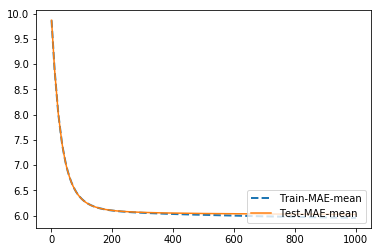

In [83]:
import matplotlib.pyplot as plt

y1 = bestCV['train-MAE-mean']
y2 = bestCV['test-MAE-mean']
x = np.arange(1,1001,1)

fig, ax = plt.subplots()

line1, = ax.plot(x, y1, '--', linewidth=2,
                 label='Train-MAE-mean')

line2, = ax.plot(x, y2, 
                 label='Test-MAE-mean')

ax.legend(loc='lower right')
plt.show()



In [84]:
print(bestParams['params'].tolist())

["{'bagging_temperature': 0.025450756467009672, 'bootstrap_type': 'Bayesian', 'iterations': 1000, 'learning_rate': 0.1985339952844135, 'loss_function': 'MAE', 'max_depth': 10.0, 'random_seed': 42, 'random_strength': 1.5110937913506746, 'task_type': 'GPU'}"]


In [85]:
import ast

hyperParameters = pd.DataFrame()
for i in range(0,len(evaluation)):
    tempParams = ast.literal_eval(evaluation.loc[i, 'params']).copy()
    hyperParameters = hyperParameters.append(pd.Series(tempParams), ignore_index = True)
    
hyperParameters['loss'] = evaluation['loss']
hyperParameters['iteration'] = evaluation['iteration']
hyperParameters['train_time'] = evaluation['train_time']
hyperParameters.head()

,bagging_temperature,bootstrap_type,iterations,learning_rate,loss_function,max_depth,random_seed,random_strength,task_type,loss,iteration,train_time
0,31.944725,Bayesian,1000.0,0.006451,MAE,9.0,42.0,45.470105,GPU,7.594822,1,12.988190
1,31.579959,Bayesian,1000.0,0.156128,MAE,8.0,42.0,41.010396,GPU,6.106659,2,15.854232
2,95.122391,Bayesian,1000.0,0.015313,MAE,9.0,42.0,83.738836,GPU,6.763571,3,2.603682
3,43.333280,Bayesian,1000.0,0.007361,MAE,9.0,42.0,44.483251,GPU,7.415420,4,2.623279
4,80.276478,Bayesian,1000.0,0.045402,MAE,3.0,42.0,81.239599,GPU,6.515809,5,2.638401


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7e14ab7ac8>,
      dtype=object)

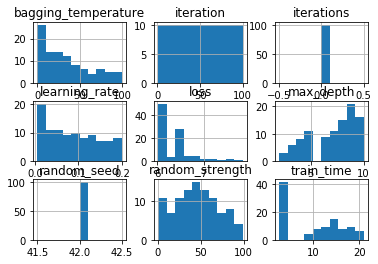

In [86]:
hyperParameters.hist()

In [87]:
hyperParameters.to_csv('results/hyperParameters.csv')